# Parametrizing SpinPulse from QPU specifications

## Introduction and setting parameters via an ```HardwareSpecs``` instance

In this example, we will use ```SpinPulse``` to realize noise-accurate simulations of a quantum computer which is parametrized by
metrics that can be experimentally measured, or predicted from fabrication, publications, etc.

 In our example, we consider that we are given the following hardware properties, which are compatible with spin qubit state-of-the-art capabilities see [[Gravier, 2025](http://arxiv.org/abs/2507.08713)].

- The one qubit gate time for $X,Y$ gates is of the order of $t_x=1\mu s$
- The one qubit gate time for $Z$ gates is of the order of $t_z=0.1\mu s$
- The two qubit gate time is of the order of $t_{zz}=1\mu s$
- The single qubit gate fidelity is of the order of $\mathcal{F}_1>0.9995$
- The two qubit gate fidelity is of the order of $\mathcal{F}_2=0.994$

And we would like ```SpinPulse``` to mimic the behavior of such a quantum computer.

As ``SpinPulse`` operates in dimensionless time units, with time steps $t_s=1$ corresponding to the resolution of the code. Based on the
given hardware properties, a meaningful choice of resolution will be $t_s=1$ ns, and accordingly we will write all coupling constants of the models in GHZ.

### Defining Hamiltonian model parameters

Knowing the required times, and choosing Gaussian pulse shapes for simplicity, we can assign the required values of the Hamiltonian parameters.

In [1]:
import numpy as np

from spin_pulse import (
    DynamicalDecoupling,
    ExperimentalEnvironment,
    HardwareSpecs,
    Shape,
)
from spin_pulse.environment.noise import NoiseType

# Gate times in our units (ns)
t_z = 100
t_x = 1_000
t_zz = 1_000
# Other parameters
coeff_duration = 5  # time_window for a gate = sigma*coeff_duration
ramp_duration = 5

##Width of the used Gaussians
sigma_z = t_z / coeff_duration
sigma_x = t_x / coeff_duration
sigma_zz = t_zz / coeff_duration

# Coupling constants needed to generate a R_{x,z}(pi), and a R_{zz}(pi/2) gate with the Gaussian shapes
delta = np.pi / (np.sqrt(2 * np.pi) * sigma_z)
B0 = np.pi / (np.sqrt(2 * np.pi) * sigma_x)
J_coupling = np.pi / (2 * np.sqrt(2 * np.pi) * sigma_zz)


def hardware_specs(n_qb):
    return HardwareSpecs(
        num_qubits=n_qb,
        B_field=B0,
        delta=delta,
        J_coupling=J_coupling,
        rotation_shape=Shape.GAUSSIAN,
        ramp_duration=ramp_duration,
        coeff_duration=coeff_duration,
    )

As a sanity check, we transpile simple single- and two-qubit gates and check that the durations correspond to our requests.

In [2]:
from qiskit import QuantumCircuit

from spin_pulse import PulseCircuit

n_qb = 1
hardware_specs_1 = hardware_specs(1)

z_circ = QuantumCircuit(n_qb)
z_circ.z(0)
z_circ_isa = hardware_specs_1.gate_transpile(z_circ)
pulse_z_circ = PulseCircuit.from_circuit(z_circ_isa, hardware_specs_1)
print("Z gate duration (ns)", pulse_z_circ.duration)

x_circ = QuantumCircuit(n_qb)
x_circ.x(0)
x_circ_isa = hardware_specs_1.gate_transpile(x_circ)
pulse_x_circ = PulseCircuit.from_circuit(x_circ_isa, hardware_specs_1)
print("X gate duration (ns) ", pulse_x_circ.duration)

n_qb = 2
hardware_specs_2 = hardware_specs(n_qb)

rzz_circ = QuantumCircuit(n_qb)
rzz_circ.rzz(np.pi / 2, 0, 1)
pulse_rzz_circ = PulseCircuit.from_circuit(rzz_circ, hardware_specs_2)
print("Bare RZZ gate duration (ns) ", pulse_rzz_circ.duration)
rzz_circ_isa = hardware_specs_2.gate_transpile(rzz_circ)
pulse_rzz_circ_isa = PulseCircuit.from_circuit(rzz_circ_isa, hardware_specs_2)
print("Sym Corrected RZZ gate duration (ns) ", pulse_rzz_circ_isa.duration)

Z gate duration (ns) 102
X gate duration (ns)  1013
Bare RZZ gate duration (ns)  1023
Sym Corrected RZZ gate duration (ns)  3060


It is also important to check that $R_{zz}(\pi/2)$ is our ``main'' entangling gate, as we can relate it to a single CNOT gate.

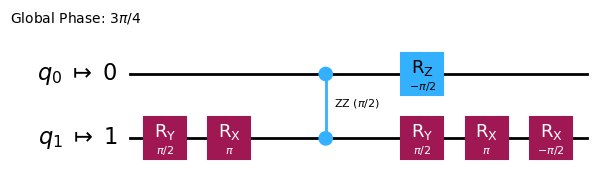

In [3]:
cnot_circ = QuantumCircuit(2)
cnot_circ.cx(0, 1)
cnot_circ_isa = hardware_specs_2.first_pass.run(cnot_circ)
cnot_circ_isa.draw("mpl")

### Experimental environment

Having parametrized our hardware specifications, we now attach an ExperimentalEnvironment to mimic the effect of noise.

``SpinPulse`` is parameterized in terms of the coherence times $T_2^*$ and $T_J^*$, whereas the available data are provided in terms of gate fidelities. We therefore infer the corresponding coherence times by reverse engineering, computing the gate fidelities for different values of $T_2^*$, and $T_J^*$ (which we write ``T2S``, ``TJS`` in our code for simplicity)

We first fix the coherence time $T_2^*$ from the value of the single qubit gate fidelity $\mathcal{F}_1$. Remember at this point that the ```duration``` argument controls the number of random realizations to average over, while the parameter ```segement_duration```.

In [4]:
def my_exp_env(T2S):
    return ExperimentalEnvironment(
        hardware_specs=hardware_specs_1,
        noise_type=NoiseType.PINK,
        T2S=T2S,
        duration=2**20,
        segment_duration=2**20,
    )

In [5]:
# We calculate single qubit gate fidelities for various values of T2S
T2s = np.arange(5_000, 12_000, 2_000)
fidelities = [pulse_x_circ.mean_fidelity(my_exp_env(T2S), x_circ) for T2S in T2s]

Text(0, 0.5, '$\\mathcal{F}_1$')

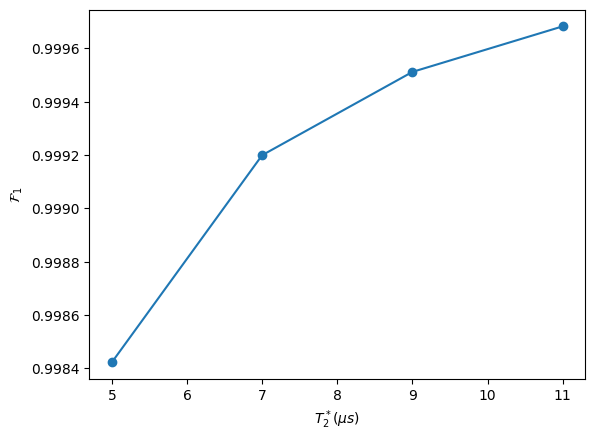

In [6]:
import matplotlib.pyplot as plt

plt.plot(T2s / 1_000, fidelities, "-o")
plt.xlabel(r"$T_2^* (\mu s)$")
plt.ylabel(r"$\mathcal{F}_1$")

We thus set $T_2^*=10\ \mu s$ to achieve the requested single qubit gate fidelity.

As a side remark, we can also calculate the $T_2^e$ echo time associated with spin echo Ramsey sequences.

In [7]:
from spin_pulse.characterization.ramsey import get_average_ramsey_contrast

T2S = 10_000  # which is 10 micro second in our units


hardware_specs_se = HardwareSpecs(
    1,
    B0,
    delta,
    J_coupling,
    Shape.GAUSSIAN,
    dynamical_decoupling=DynamicalDecoupling.SPIN_ECHO,
)
ramsey_durations = range(6_000, 60_000, 12_000)

exp_env = my_exp_env(T2S)
contrasts_se = get_average_ramsey_contrast(hardware_specs_se, exp_env, ramsey_durations)

The blue line represents the decay of the Ramsey contrast, without spin echo, and is well approximated by the analytical expression presented in our model (green), while the orange Gaussian line gives the right order of magnitude. The blue dots represent the spin echo sequence and corresponds to $T_2^e\approx 50 \mu s$

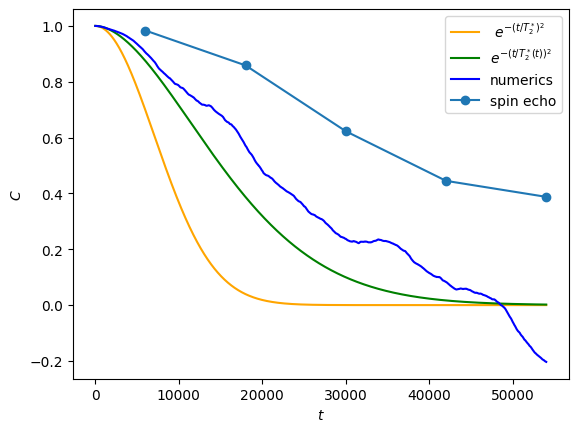

In [8]:
exp_env.time_traces[0].plot_ramsey_contrast(ramsey_durations[-1])
plt.plot(ramsey_durations, contrasts_se, "-o", label="spin echo")
plt.legend()

Finally we consider the two qubit gate fidelity  in order to adjust the value of $T_J^*$.

In [9]:
def my_exp_env(TJS):
    return ExperimentalEnvironment(
        hardware_specs=hardware_specs_2,
        noise_type=NoiseType.PINK,
        T2S=T2S,
        duration=2**20,
        segment_duration=2**20,
        TJS=TJS,
    )


TJs = np.arange(2_000, 12_000, 3_000)

twoq_fidelities = [
    pulse_rzz_circ_isa.mean_fidelity(my_exp_env(TJS), rzz_circ) for TJS in TJs
]

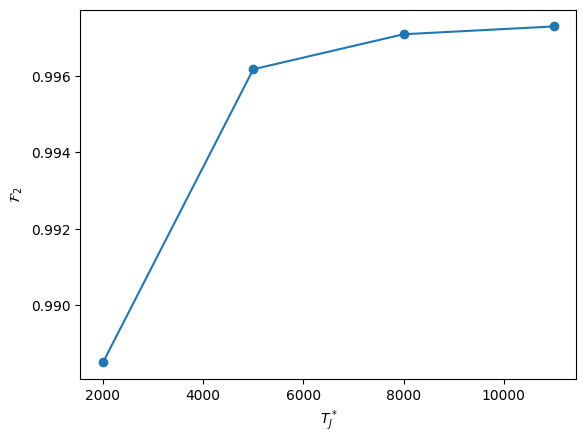

In [10]:
plt.plot(TJs, twoq_fidelities, "-o")
plt.xlabel("$T_J^*$")
plt.ylabel(r"$\mathcal{F}_2$")
TJS = 5_000

Therefore we achieve $\mathcal{F}_2=0.996$ by setting $T_J^\star=5\ \mu s$

## Printing calibrated hardware specs and experimental environments

Our parametrization is complete, we can print the final settings for our ```HardwareSpecs``` and ```ExperimentalEnvironment``` classes. This can be used to realize noise-accurate simulations of arbitrary input quantum circuits (simply changing the number of qubits accordingly).

In [11]:
print(hardware_specs_2)
print("---")
TJS = 5_000
print(my_exp_env(TJS))

HardwareSpec:
  num_qubits: 2
  B_field: 0.006266570686577501
  delta: 0.06266570686577502
  J_coupling: 0.0031332853432887507
  rotation_shape: Shape.GAUSSIAN
  ramp_duration: 5
  coeff_duration: 5
  dynamical_decoupling: None
---


ExperimentalEnvironment:
  Qubits: 2
  Noise Type: NoiseType.PINK
  T2S (qubit dephasing): 10000
  TJS (coupling dephasing): 5000
  Duration: 1048576
  Segment Duration: 1048576
  Only Idle: False
  J Coupling: 0.0031332853432887507
  Time Traces Generated: 2
  Seed: None
  Coupling Time Traces Generated: 1
